# Machine Learning CC Fraud Detection

### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from datetime import datetime, date
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,RandomizedSearchCV,StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Read in data for train and test

In [3]:
# Train data is from kaggle 
# https://www.kaggle.com/datasets/kartik2112/fraud-detection?resource=download&select=fraudTrain.csv
train_df = pd.read_csv("fraudTrain.csv")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [4]:
train_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [5]:
test_df = pd.read_csv("fraud_detection.csv")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Row                    555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  float64
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amount                 555719 non-null  float64
 6   first name             555719 non-null  object 
 7   last name              555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zipcode                555719 non-null  int64  
 13  latitude               555719 non-null  float64
 14  longitude              555719 non-nu

In [6]:
test_df.head()

,Row,trans_date_trans_time,cc_num,merchant,category,amount,first name,last name,gender,street,city,state,zipcode,latitude,longitude,city_pop,job,dateofbirth,transaction_number,unix_time,merchant_lat,merchant_long,is_fraud
0,0,2020/06/21 12:14,2.290000e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968/03/19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020/06/21 12:14,3.570000e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990/01/17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020/06/21 12:14,3.600000e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970/10/21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020/06/21 12:15,3.590000e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987/07/25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020/06/21 12:15,3.530000e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955/07/06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


### Cleaning train data

In [7]:
train_df.drop_duplicates()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,UT,84735,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0
1296671,1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,MD,21790,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0
1296672,1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,NM,88325,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,SD,57756,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0


In [8]:
train_df['is_fraud'].value_counts(normalize=True)

0    0.994211
1    0.005789
Name: is_fraud, dtype: float64

In [9]:
# Drop unnecessary columns
drop_cols = ['Unnamed: 0', 'cc_num', 'street', 'zip', 'trans_num', 'unix_time' ] 
train_df.drop(drop_cols, axis = 1, inplace = True)

In [10]:
# Create full name
train_df['full_name'] = train_df['first']+" "+train_df['last']
train_df.drop(['first','last'], axis=1, inplace=True)

In [11]:
merchant_name = []
for i in train_df['merchant']:
    merchant_name.append(i[6:])

In [12]:
train_df['merchant'] = merchant_name
train_df.head()

,trans_date_trans_time,merchant,category,amt,gender,city,state,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,full_name
0,2019-01-01 00:00:18,"Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,36.011293,-82.048315,0,Jennifer Banks
1,2019-01-01 00:00:44,"Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,WA,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,49.159047,-118.186462,0,Stephanie Gill
2,2019-01-01 00:00:51,Lind-Buckridge,entertainment,220.11,M,Malad City,ID,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,43.150704,-112.154481,0,Edward Sanchez
3,2019-01-01 00:01:16,"Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,MT,46.2306,-112.1138,1939,Patent attorney,1967-01-12,47.034331,-112.561071,0,Jeremy White
4,2019-01-01 00:03:06,Keeling-Crist,misc_pos,41.96,M,Doe Hill,VA,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,38.674999,-78.632459,0,Tyler Garcia


In [13]:
# Create a column age
train_df['dob'] = pd.to_datetime(train_df['dob'])

def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [14]:
train_df['age'] = train_df["dob"].apply(calculate_age)

In [15]:
# Create a column age_group
train_df["age_group"] = pd.cut(train_df["age"], bins=[0,25,40,60,80,9999], labels = ["<25","25-40","40-60","60-80",">80"])

In [16]:
train_df['trans_date_trans_time'] = pd.to_datetime(train_df['trans_date_trans_time'])

train_df['year'] = pd.DatetimeIndex(train_df['trans_date_trans_time']).year
train_df['month'] = pd.DatetimeIndex(train_df['trans_date_trans_time']).month
train_df['day_of_week'] = train_df['trans_date_trans_time'].dt.day_name()
train_df['transaction_hour'] = train_df['trans_date_trans_time'].dt.hour

In [17]:
train_df.head()

,trans_date_trans_time,merchant,category,amt,gender,city,state,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,full_name,age,age_group,year,month,day_of_week,transaction_hour
0,2019-01-01 00:00:18,"Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,36.011293,-82.048315,0,Jennifer Banks,35,25-40,2019,1,Tuesday,0
1,2019-01-01 00:00:44,"Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,WA,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,49.159047,-118.186462,0,Stephanie Gill,44,40-60,2019,1,Tuesday,0
2,2019-01-01 00:00:51,Lind-Buckridge,entertainment,220.11,M,Malad City,ID,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,43.150704,-112.154481,0,Edward Sanchez,61,60-80,2019,1,Tuesday,0
3,2019-01-01 00:01:16,"Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,MT,46.2306,-112.1138,1939,Patent attorney,1967-01-12,47.034331,-112.561071,0,Jeremy White,56,40-60,2019,1,Tuesday,0
4,2019-01-01 00:03:06,Keeling-Crist,misc_pos,41.96,M,Doe Hill,VA,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,38.674999,-78.632459,0,Tyler Garcia,37,25-40,2019,1,Tuesday,0


In [18]:
train_df.drop(["trans_date_trans_time", "full_name", "year", "merchant", "city", "city_pop", "job", "dob",
               "age", "lat", "long", "merch_lat", "merch_long"], axis=1, inplace=True)
train_df.rename(columns = {'amt':'amount'}, inplace = True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   category          1296675 non-null  object  
 1   amount            1296675 non-null  float64 
 2   gender            1296675 non-null  object  
 3   state             1296675 non-null  object  
 4   is_fraud          1296675 non-null  int64   
 5   age_group         1296675 non-null  category
 6   month             1296675 non-null  int64   
 7   day_of_week       1296675 non-null  object  
 8   transaction_hour  1296675 non-null  int64   
dtypes: category(1), float64(1), int64(3), object(4)
memory usage: 80.4+ MB


### Cleaning test data

In [19]:
test_df['is_fraud'].value_counts(normalize=True)

0    0.99614
1    0.00386
Name: is_fraud, dtype: float64

In [20]:
# Drop unnecessary columns
drop_cols = ['Row', 'cc_num', 'street', 'zipcode', 'transaction_number', 'unix_time' ] 
test_df.drop(drop_cols, axis = 1, inplace = True)

In [21]:
# Create full name
test_df['full_name'] = test_df['first name']+" "+test_df['last name']
test_df.drop(['first name','last name'], axis=1, inplace=True)

In [22]:
merchant_name = []
for i in test_df['merchant']:
    merchant_name.append(i[6:])

In [23]:
test_df['merchant'] = merchant_name
test_df.head()

,trans_date_trans_time,merchant,category,amount,gender,city,state,latitude,longitude,city_pop,job,dateofbirth,merchant_lat,merchant_long,is_fraud,full_name
0,2020/06/21 12:14,Kirlin and Sons,personal_care,2.86,M,Columbia,SC,33.9659,-80.9355,333497,Mechanical engineer,1968/03/19,33.986391,-81.200714,0,Jeff Elliott
1,2020/06/21 12:14,Sporer-Keebler,personal_care,29.84,F,Altonah,UT,40.3207,-110.4360,302,"Sales professional, IT",1990/01/17,39.450498,-109.960431,0,Joanne Williams
2,2020/06/21 12:14,"Swaniawski, Nitzsche and Welch",health_fitness,41.28,F,Bellmore,NY,40.6729,-73.5365,34496,"Librarian, public",1970/10/21,40.495810,-74.196111,0,Ashley Lopez
3,2020/06/21 12:15,Haley Group,misc_pos,60.05,M,Titusville,FL,28.5697,-80.8191,54767,Set designer,1987/07/25,28.812398,-80.883061,0,Brian Williams
4,2020/06/21 12:15,Johnston-Casper,travel,3.19,M,Falmouth,MI,44.2529,-85.0170,1126,Furniture designer,1955/07/06,44.959148,-85.884734,0,Nathan Massey


In [24]:
# Create a column age
test_df["dateofbirth"] = pd.to_datetime(test_df["dateofbirth"])

def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [25]:
test_df["age"] = test_df["dateofbirth"].apply(calculate_age)

In [26]:
# Create age_group column
test_df["age_group"] = pd.cut(test_df["age"], bins=[0,25,40,60,80,9999], labels = ["<25","25-40","40-60","60-80",">80"])

In [27]:
test_df['trans_date_trans_time'] = pd.to_datetime(test_df['trans_date_trans_time'])

test_df['year'] = pd.DatetimeIndex(test_df['trans_date_trans_time']).year
test_df['month'] = pd.DatetimeIndex(test_df['trans_date_trans_time']).month
test_df['day_of_week'] = test_df['trans_date_trans_time'].dt.day_name()
test_df['transaction_hour'] = test_df['trans_date_trans_time'].dt.hour

In [28]:
test_df.head()

,trans_date_trans_time,merchant,category,amount,gender,city,state,latitude,longitude,city_pop,job,dateofbirth,merchant_lat,merchant_long,is_fraud,full_name,age,age_group,year,month,day_of_week,transaction_hour
0,2020-06-21 12:14:00,Kirlin and Sons,personal_care,2.86,M,Columbia,SC,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,33.986391,-81.200714,0,Jeff Elliott,55,40-60,2020,6,Sunday,12
1,2020-06-21 12:14:00,Sporer-Keebler,personal_care,29.84,F,Altonah,UT,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,39.450498,-109.960431,0,Joanne Williams,33,25-40,2020,6,Sunday,12
2,2020-06-21 12:14:00,"Swaniawski, Nitzsche and Welch",health_fitness,41.28,F,Bellmore,NY,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,40.495810,-74.196111,0,Ashley Lopez,52,40-60,2020,6,Sunday,12
3,2020-06-21 12:15:00,Haley Group,misc_pos,60.05,M,Titusville,FL,28.5697,-80.8191,54767,Set designer,1987-07-25,28.812398,-80.883061,0,Brian Williams,35,25-40,2020,6,Sunday,12
4,2020-06-21 12:15:00,Johnston-Casper,travel,3.19,M,Falmouth,MI,44.2529,-85.0170,1126,Furniture designer,1955-07-06,44.959148,-85.884734,0,Nathan Massey,67,60-80,2020,6,Sunday,12


In [29]:
test_df.drop(["trans_date_trans_time", "full_name", "year", "merchant", "city", "city_pop", "job", "dateofbirth",
             "age", "latitude", "longitude", "merchant_lat", "merchant_long"], axis=1, inplace=True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   category          555719 non-null  object  
 1   amount            555719 non-null  float64 
 2   gender            555719 non-null  object  
 3   state             555719 non-null  object  
 4   is_fraud          555719 non-null  int64   
 5   age_group         555719 non-null  category
 6   month             555719 non-null  int64   
 7   day_of_week       555719 non-null  object  
 8   transaction_hour  555719 non-null  int64   
dtypes: category(1), float64(1), int64(3), object(4)
memory usage: 34.4+ MB


### Data splitting

In [30]:
# separate  X_train and y_train 
y_train = train_df.pop("is_fraud")
X_train = train_df

In [31]:
# separate  X_test and y_test
y_test = test_df.pop("is_fraud")
X_test = test_df

### Dummy variables

In [32]:
X_train['transaction_hour']= X_train['transaction_hour'].astype(str)
X_train['month']= X_train['month'].astype(str)

X_test['transaction_hour']= X_test['transaction_hour'].astype(str)
X_test['month']= X_test['month'].astype(str)

In [33]:
cat_cols = ["category", "state", "month", "day_of_week", "transaction_hour", 'gender', 'age_group']

In [34]:
# Train data
dummy = pd.get_dummies(X_train[cat_cols], drop_first=True)

# Adding the results back
X_train = pd.concat([X_train, dummy], axis=1)
X_train.drop(cat_cols, axis=1, inplace=True)
X_train.head()

,amount,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,transaction_hour_1,transaction_hour_10,transaction_hour_11,transaction_hour_12,transaction_hour_13,transaction_hour_14,transaction_hour_15,transaction_hour_16,transaction_hour_17,transaction_hour_18,transaction_hour_19,transaction_hour_2,transaction_hour_20,transaction_hour_21,transaction_hour_22,transaction_hour_23,transaction_hour_3,transaction_hour_4,transaction_hour_5,transaction_hour_6,transaction_hour_7,transaction_hour_8,transaction_hour_9,gender_M,age_group_25-40,age_group_40-60,age_group_60-80,age_group_>80
0,4.97,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,107.23,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,220.11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,45.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,41.96,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0


In [36]:
# Scaling train data
scaler = MinMaxScaler()
scale_var = ["amount"]
X_train[scale_var] = scaler.fit_transform(X_train[scale_var])

In [37]:
# Test data
dummy1 = pd.get_dummies(X_test[cat_cols], drop_first=True)

# Adding the results back
X_test = pd.concat([X_test, dummy1], axis=1)
X_test.drop(cat_cols, axis=1, inplace=True)
X_test.head()

,amount,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,month_11,month_12,month_6,month_7,month_8,month_9,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,transaction_hour_1,transaction_hour_10,transaction_hour_11,transaction_hour_12,transaction_hour_13,transaction_hour_14,transaction_hour_15,transaction_hour_16,transaction_hour_17,transaction_hour_18,transaction_hour_19,transaction_hour_2,transaction_hour_20,transaction_hour_21,transaction_hour_22,transaction_hour_23,transaction_hour_3,transaction_hour_4,transaction_hour_5,transaction_hour_6,transaction_hour_7,transaction_hour_8,transaction_hour_9,gender_M,age_group_25-40,age_group_40-60,age_group_60-80,age_group_>80
0,2.86,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,29.84,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,41.28,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,60.05,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
4,3.19,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [38]:
X_test[scale_var] = scaler.fit_transform(X_test[scale_var])

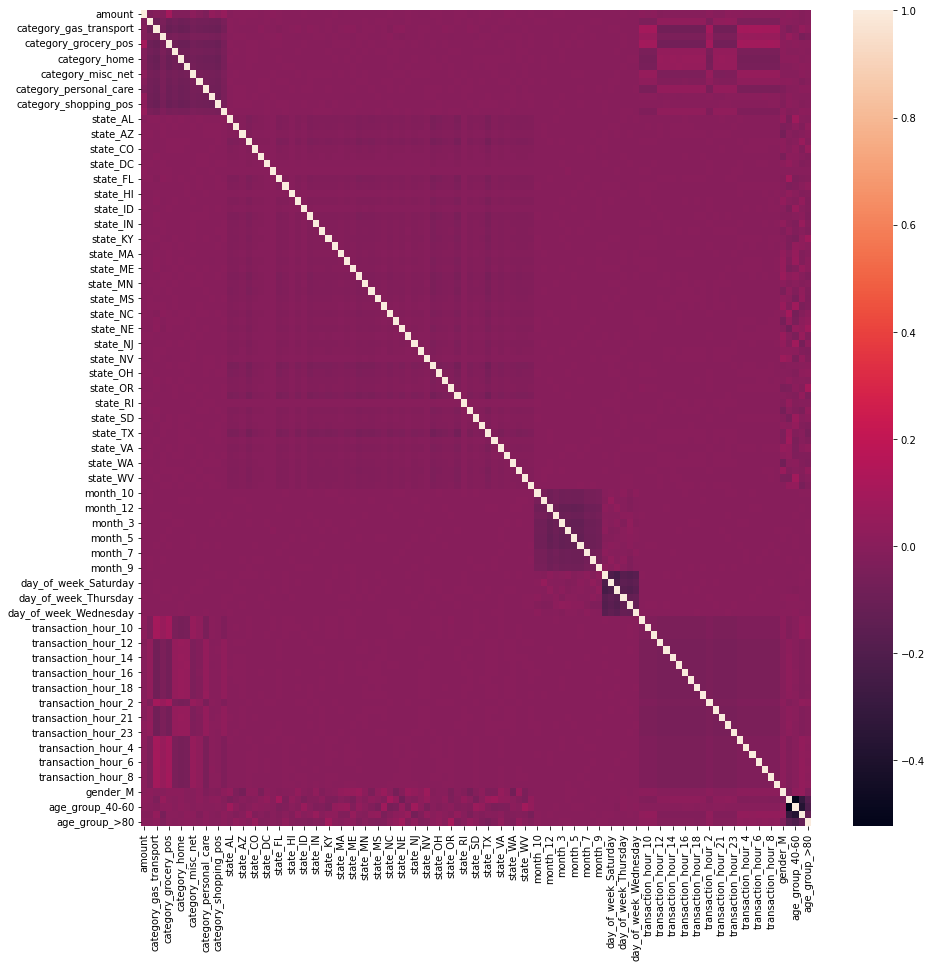

In [39]:
#Check heatmap for correlation
plt.figure(figsize=(15,15))
sns.heatmap(X_train.corr())
plt.show()

### Feature Selection

In [40]:
rf = RandomForestClassifier(n_estimators = 20).fit(X_train, y_train)

feat = X_train.columns

In [41]:
imp_df = pd.DataFrame({
    "var": X_train.columns,
    "imp": rf.feature_importances_
})

In [42]:
imp_df.sort_values(by="imp", ascending=False)

,var,imp
0,amount,0.479166
4,category_grocery_pos,0.058841
107,age_group_60-80,0.024917
95,transaction_hour_22,0.023808
96,transaction_hour_23,0.022556
104,gender_M,0.018871
2,category_gas_transport,0.015526
105,age_group_25-40,0.013519
9,category_misc_pos,0.013493
8,category_misc_net,0.012425


In [43]:
cols_for_model = ["amount", "category_grocery_pos", "transaction_hour_23", "transaction_hour_22",
                       "category_gas_transport", "age_group_60-80", "gender_M", "age_group_25-40",
                       "age_group_40-60", "category_misc_net", "category_misc_pos", "category_shopping_net",
                       "age_group_>80", "day_of_week_Sunday", "day_of_week_Monday", "day_of_week_Saturday",
                       "category_shopping_pos", "category_travel", "day_of_week_Tuesday", "day_of_week_Thursday"]

In [44]:
X_train = X_train[cols_for_model]

In [45]:
X_test = X_test[cols_for_model]

### Data Balancing

In [46]:
# SMOTE
smt = SMOTE(random_state=2023, k_neighbors=5)
X_resampled, y_resampled = smt.fit_resample(X_train, y_train)
len(X_resampled)

2578338

### Logistic regression

In [47]:
lreg = LogisticRegression()
lreg.fit(X_resampled, y_resampled)

y_pred_lreg = lreg.predict(X_test)

In [48]:
confusion_matrix(y_test, y_pred_lreg)

array([[451748, 101826],
       [   378,   1767]])

In [49]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_lreg))
print ('F1 score: ', f1_score(y_test, y_pred_lreg))
print ('Recall: ', recall_score(y_test, y_pred_lreg))
print ('Precision: ', precision_score(y_test, y_pred_lreg))

Accuracy:  0.8160869072318924
F1 score:  0.03342223231004937
Recall:  0.8237762237762237
Precision:  0.017057137065245722


### Decision tree

In [50]:
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_resampled, y_resampled)

y_pred_dtc = dtc.predict(X_test)

In [51]:
confusion_matrix(y_test, y_pred_dtc)

array([[519284,  34290],
       [   743,   1402]])

In [53]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_dtc))
print ('F1 score: ', f1_score(y_test, y_pred_dtc))
print ('Recall: ', recall_score(y_test, y_pred_dtc))
print ('Precision: ', precision_score(y_test, y_pred_dtc))

Accuracy:  0.9369591466190647
F1 score:  0.07410735523429447
Recall:  0.6536130536130537
Precision:  0.039280511038888265


### Random forest

In [54]:
rf = RandomForestClassifier()
rf.fit(X_resampled, y_resampled)

y_pred_rf = rf.predict(X_test)

In [55]:
confusion_matrix(y_test, y_pred_rf)

array([[520108,  33466],
       [   672,   1473]])

In [56]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_rf))
print ('F1 score: ', f1_score(y_test, y_pred_rf))
print ('Recall: ', recall_score(y_test, y_pred_rf))
print ('Precision: ', precision_score(y_test, y_pred_rf))

Accuracy:  0.9385696728022616
F1 score:  0.07944126847157804
Recall:  0.6867132867132867
Precision:  0.04215919173416526


### XGBoost

In [58]:
xgb = XGBClassifier()
xgb.fit(X_resampled, y_resampled)

y_pred_xgb = xgb.predict(X_test)

In [59]:
confusion_matrix(y_test, y_pred_xgb)

array([[528301,  25273],
       [   529,   1616]])

In [60]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_xgb))
print ('F1 score: ', f1_score(y_test, y_pred_xgb))
print ('Recall: ', recall_score(y_test, y_pred_xgb))
print ('Precision: ', precision_score(y_test, y_pred_xgb))

Accuracy:  0.9535700596884397
F1 score:  0.11131776537852173
Recall:  0.7533799533799533
Precision:  0.060098925211052846


### PCA

In [61]:
from sklearn.decomposition import PCA

In [62]:
pca = PCA()
X_pca = pca.fit_transform(X_train)

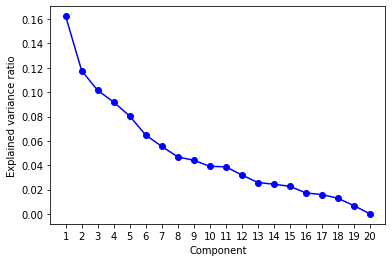

In [63]:
plt.plot(np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, 'bo-')
plt.xticks(np.arange(1, pca.n_components_ + 1))
plt.xlabel('Component')
plt.ylabel('Explained variance ratio')
plt.show()

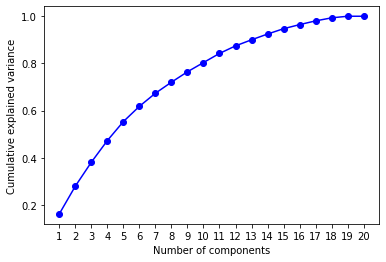

In [64]:
# Create cumulative explained variance plot
plt.plot(np.arange(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.xticks(np.arange(1, pca.n_components_ + 1))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [65]:
pca_1 = PCA(n_components=11)
X_pca_1 = pca_1.fit_transform(X_train)

In [68]:
X_test_pca_1 = pca_1.fit_transform(X_test)

In [66]:
# SMOTE
smt_pca = SMOTE(random_state=2023, k_neighbors=5)
X_resampled_pca, y_resampled_pca = smt_pca.fit_resample(X_pca_1, y_train)
len(X_resampled_pca)

2578338

In [69]:
# Logistic regression
lreg_pca = LogisticRegression()
lreg_pca.fit(X_resampled_pca, y_resampled_pca)

y_pred_lreg_pca = lreg_pca.predict(X_test_pca_1)

In [70]:
confusion_matrix(y_test, y_pred_lreg_pca)

array([[315693, 237881],
       [   712,   1433]])

In [71]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_lreg_pca))
print ('F1 score: ', f1_score(y_test, y_pred_lreg_pca))
print ('Recall: ', recall_score(y_test, y_pred_lreg_pca))
print ('Precision: ', precision_score(y_test, y_pred_lreg_pca))

Accuracy:  0.5706589121480461
F1 score:  0.01186950993750492
Recall:  0.6680652680652681
Precision:  0.005987948887236016


In [72]:
# Decision tree
dtc_pca = DecisionTreeClassifier(random_state=0)
dtc_pca.fit(X_resampled_pca, y_resampled_pca)

y_pred_dtc_pca = dtc_pca.predict(X_test_pca_1)

In [73]:
confusion_matrix(y_test, y_pred_dtc_pca)

array([[298331, 255243],
       [  1517,    628]])

In [74]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_dtc_pca))
print ('F1 score: ', f1_score(y_test, y_pred_dtc_pca))
print ('Recall: ', recall_score(y_test, y_pred_dtc_pca))
print ('Precision: ', precision_score(y_test, y_pred_dtc_pca))

Accuracy:  0.5379679298350425
F1 score:  0.004867915168051593
Recall:  0.29277389277389276
Precision:  0.0024543617682347744


In [75]:
# Random forest
rf_pca = RandomForestClassifier()
rf_pca.fit(X_resampled_pca, y_resampled_pca)

y_pred_rf_pca = rf_pca.predict(X_test_pca_1)

In [76]:
confusion_matrix(y_test, y_pred_rf_pca)

array([[176141, 377433],
       [   879,   1266]])

In [77]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_rf_pca))
print ('F1 score: ', f1_score(y_test, y_pred_rf_pca))
print ('Recall: ', recall_score(y_test, y_pred_rf_pca))
print ('Precision: ', precision_score(y_test, y_pred_rf_pca))

Accuracy:  0.31923867998034977
F1 score:  0.006648391467372468
Recall:  0.5902097902097903
Precision:  0.0033430244072469163


In [78]:
#XGBoost
xgb_pca = XGBClassifier()
xgb_pca.fit(X_resampled_pca, y_resampled_pca)

y_pred_xgb_pca = xgb_pca.predict(X_test_pca_1)

In [79]:
confusion_matrix(y_test, y_pred_xgb_pca)

array([[374154, 179420],
       [  1048,   1097]])

In [80]:
print ('Accuracy: ', accuracy_score(y_test, y_pred_xgb_pca))
print ('F1 score: ', f1_score(y_test, y_pred_xgb_pca))
print ('Recall: ', recall_score(y_test, y_pred_xgb_pca))
print ('Precision: ', precision_score(y_test, y_pred_xgb_pca))

Accuracy:  0.6752531405260572
F1 score:  0.01201125576200852
Recall:  0.5114219114219114
Precision:  0.006076989978783162
